# Thicket and Extra-P: Thicket Tutorial

Thicket is a python-based toolkit for Exploratory Data Analysis (EDA) of parallel performance data that enables performance optimization and understanding of applications’ performance on supercomputers. It bridges the performance tool gap between being able to consider only a single instance of a simulation run (e.g., single platform, single measurement tool, or single scale) and finding actionable insights in multi-dimensional, multi-scale, multi-architecture, and multi-tool performance datasets.

#### NOTE: An interactive version of this notebook is available in the Binder environment.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/llnl/thicket-tutorial/develop)

# Thicket Modeling Example

This notebook provides an example for using Thicket's modeling feature. The modeling capability relies on _Extra-P_ - a tool for empirical performance modeling. It can perform N-parameter modeling with up to 3 parameters (N <= 3). The models follow a so-called _Performance Model Normal Form (PMNF)_ that expresses models as a summation of polynomial and logarithmic terms. One of the biggest advantages of this modeling method is that the produced models are human-readable and easily understandable.

***

## 1. Import Necessary Packages

To explore the capabilities of thicket with Extra-P, we begin by importing necessary packages.

In [1]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from IPython.display import HTML

import thicket as th
import hatchet as ht
from thicket.model_extrap import ExtrapInterface

display(HTML("<style>.container { width:80% !important; }</style>"))

<IPython.core.display.Javascript object>

## 2. Define Dataset Paths and Names

In this example, we use an MPI scaling study, profiled with Caliper, that has metadata about the runs. The data is also already aggregated, which means we can provide the data to Extra-P as-is.

In [2]:
data = "../data/lulesh/"
thicket = th.Thicket.from_caliperreader(data)

Specifically, the metadata table for this set of profiles contains a `jobsize` column, which provides the amount of cores used for each profile.

In [3]:
thicket.metadata

,cali.caliper.version,mpi.world.size,spot.metrics,spot.timeseries.metrics,spot.format.version,spot.options,spot.channels,cali.channel,user,launchdate,...,problem_size,num_regions,region_cost,region_balance,Compiler Name,Compiler Version,Built by,Compiler Flags,elapsed_time,figure_of_merit
profile,,,,,,,,,,,,,,,,,,,,,
9769411,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043783,...,30,11,1,1,GNU,10.3.1,ritter5,,178.482981,41282.322551
11813938,2.11.0-dev,216,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694046771,...,20,11,1,1,GNU,10.3.1,ritter5,,65.459871,112560.442119
23525129,2.11.0-dev,27,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694042822,...,50,11,1,1,GNU,10.3.1,ritter5,,961.691803,18887.807856
31414915,2.11.0-dev,125,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694044580,...,20,11,1,1,GNU,10.3.1,ritter5,,44.857425,78403.965497
44128685,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043936,...,40,11,1,1,GNU,10.3.1,ritter5,,569.652628,41366.065623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160038193,2.11.0-dev,125,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694044509,...,10,11,1,1,GNU,10.3.1,ritter5,,4.738553,43842.497474
4180439836,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043262,...,10,11,1,1,GNU,10.3.1,ritter5,,3.340089,24794.551813
4194772873,2.11.0-dev,64,"min#inclusive#sum#time.duration,max#inclusive#...",,2,"node.order,profile.mpi,time.exclusive",regionprofile,spot,ritter5,1694043481,...,20,11,1,1,GNU,10.3.1,ritter5,,34.795095,40818.626358


## 3. More Information on a Function
***
You can use the `help()` method within Python to see the information for a given object. You can do this by typing `help(object)`. 
This will allow you to see the arguments for the function, and what will be returned. An example is below.

In [4]:
help(ExtrapInterface)

Help on class ExtrapInterface in module thicket.model_extrap:

class ExtrapInterface(builtins.object)
 |  ExtrapInterface() -> None
 |  
 |  A class that functions as an interface between Thicket and Extra-P 
 |  to load the data from a thicket into Extra-P, create performance models,
 |  append them to a thicket, and display the models.
 |  
 |  Methods defined here:
 |  
 |  __init__(self) -> None
 |      Create a new Extra-P Interface object.
 |  
 |  complexity_statsframe(self, thicket: thicket.thicket.Thicket, columns: list[str] = None, eval_targets: list[list[float]] = None) -> None
 |      Analyzes the complexity of the Extra-P models for the given thicket statsframe and the list of selected columns (metrics) for a given target evaluation scale. Then adds the results back into the statsframe.
 |      
 |      Args:
 |          columns (list[str], optional): A list of columns (metrics) that should be considered. Defaults to None.
 |          eval_targets (list[list(float)], optio

## 3. Create Models

First, we instatiate an Extra-P interface to create performance models and more.

In [5]:
extrap_interface = ExtrapInterface()

Then, we create the performance models by passing the thicket object that contains the performance measurements to the `create_models()` function of the `ExtrapInterface`. In order to create the models the interface requires some more information. First, we need to provide the names of the parameters that should be considered for modeling, e.g., the `jobsize`. The `create_models()` function will grab this column from the metadata table to use as our parameter. We also sub-select some metrics, since this dataset has a lot of metrics (otherwise the modeling will take a long time to do all metrics). Finally, we provide a name for the model configuration that the function is going to create for us. Extra-P will internally use the provided name as a unique identifier for modeling experiments. This will come in handy when experimenting with different modeling parameters, metrics, and modeler configurations.

In [6]:
extrap_interface.create_models(thicket, 
                               parameters=[
                                   "jobsize",
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)",
                                   ],
                               model_name="config1")

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \log_2{p}^{1}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


### Creating Multi-Parameter Models

Extra-P support multi-parameter modeling. Consequently you can analyze multiple application parameters with Thicket and Extra-P. To create performance models considering multiple parameters simply provide them for the `parameters` variable of the `create_models()` function. The code below shows an example.

In [7]:
thicket_multi = th.Thicket.from_caliperreader(data)
extrap_interface_multi = ExtrapInterface()
extrap_interface_multi.create_models(thicket_multi, 
                               parameters=[
                                   "jobsize",
                                   "problem_size"
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)",
                                   ],
                               model_name="config1")

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$5.514\times10^{−4}+6.196\times10^{−6}\cdot q^{7/4}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


## 4. Models Dataframe

The created performance models including some statistical quality control metrics such as the RSS (residual sum of squares) or the SMAPE (symmetric mean absolute percentage error) are stored in thicket's aggregated statistics table.

In [8]:
thicket.statsframe.dataframe

,name,Avg time/rank (exc)_extrap-model,Avg time/rank (exc)_RSS_extrap-model,Avg time/rank (exc)_rRSS_extrap-model,Avg time/rank (exc)_SMAPE_extrap-model,Avg time/rank (exc)_AR2_extrap-model,Avg time/rank (exc)_RE_extrap-model
node,,,,,,,
"{'name': 'MPI_Barrier', 'type': 'function'}",MPI_Barrier,$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \...,1.447227e-06,8.545707,48.405904,0.617853,0.685289
"{'name': 'MPI_Comm_dup', 'type': 'function'}",MPI_Comm_dup,$2.033\times10^{−5}+1.605\times10^{−7}\cdot p^...,5.055366e-08,8.842384,69.719797,-0.113187,0.837009
"{'name': 'MPI_Finalize', 'type': 'function'}",MPI_Finalize,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Finalized', 'type': 'function'}",MPI_Finalized,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Initialized', 'type': 'function'}",MPI_Initialized,$1.833\times10^{−6}$,8.333333e-13,0.729167,17.050298,1.000000,0.833333
"{'name': 'main', 'type': 'function'}",main,$8.209\times10^{−3}+3.719\times10^{−4}\cdot \l...,6.126005e-07,0.006114,3.256699,0.743588,0.027427
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,$-9.937\times10^{−3}+7.143\times10^{−3}\cdot p...,3.033116e-06,0.007269,3.287004,0.995762,0.027221
"{'name': 'MPI_Irecv', 'type': 'function'}",MPI_Irecv,$-1.201\times10^{−2}+8.223\times10^{−3}\cdot p...,1.678652e-06,0.003539,2.657153,0.998228,0.021927
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,$1.236\times10^{−3}+3.694\times10^{−4}\cdot p^...,4.971435e-07,0.014465,3.581461,0.997715,0.030795


## 5. Show the Models Dataframe with Embedded Plots

(For every `node`, sub-selected `metric` combination)

Besides the thicket object containing the models one can provide a variety of plotting options to the `to_html()` function that will change the displayed plots. One can for example select between displaying the mean, median, min, max measured metric values. Furthermore, one can display statistical values such as the RSS and SMAPE.

,Avg time/rank (exc)_extrap-model
node,
"{'name': 'MPI_Barrier', 'type': 'function'}",
"{'name': 'MPI_Comm_dup', 'type': 'function'}",
"{'name': 'MPI_Finalize', 'type': 'function'}",
"{'name': 'MPI_Finalized', 'type': 'function'}",
"{'name': 'MPI_Initialized', 'type': 'function'}",
"{'name': 'main', 'type': 'function'}",
"{'name': 'CommRecv', 'type': 'function'}",
"{'name': 'MPI_Irecv', 'type': 'function'}",
"{'name': 'CommSBN', 'type': 'function'}",

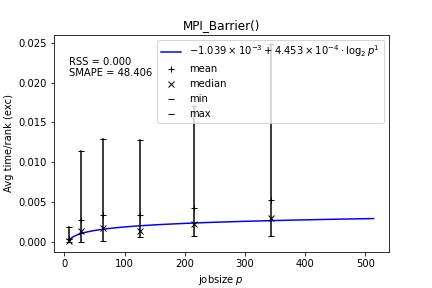
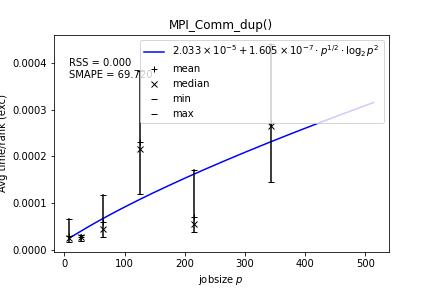
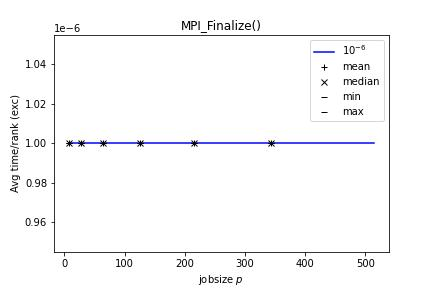
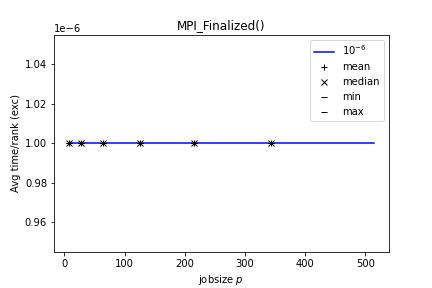
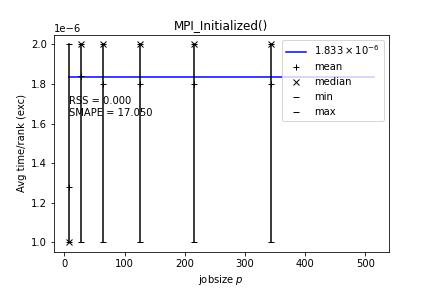
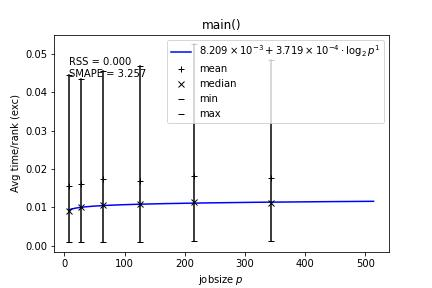
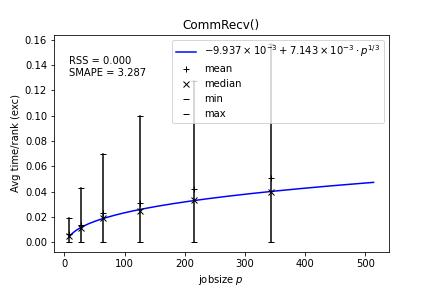
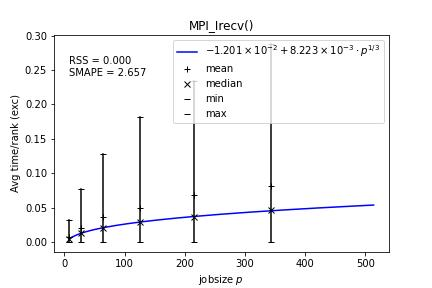
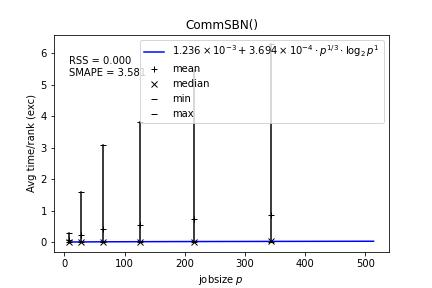
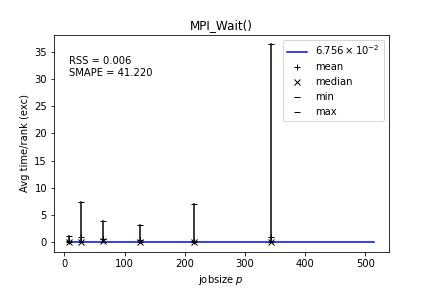
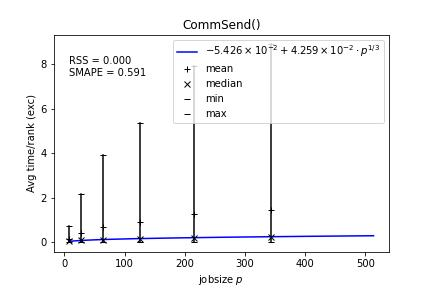
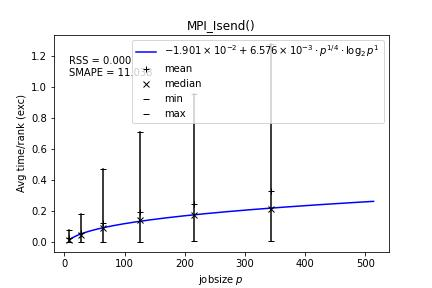
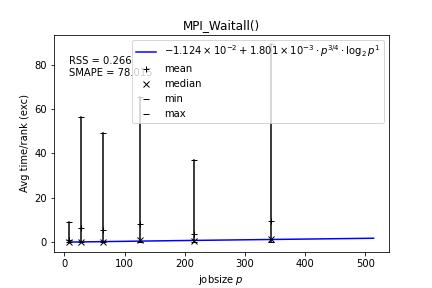
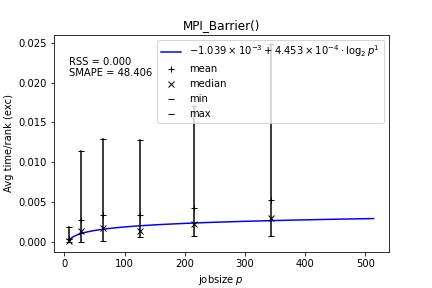
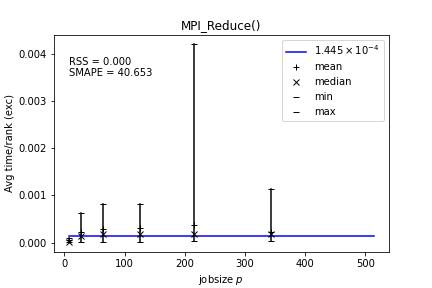
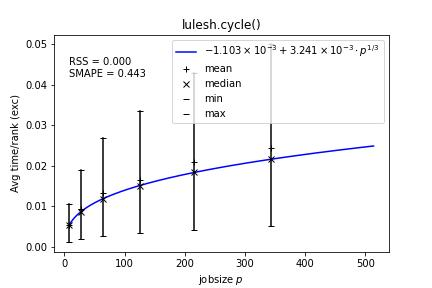
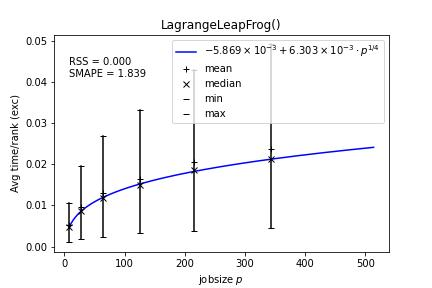
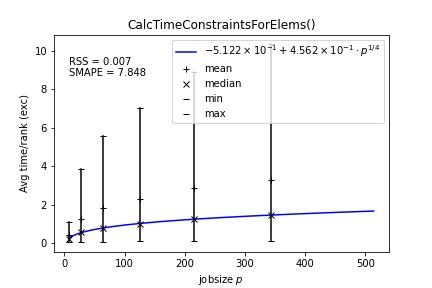
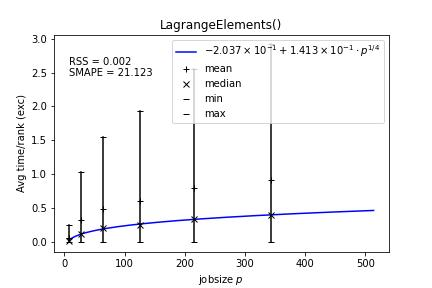
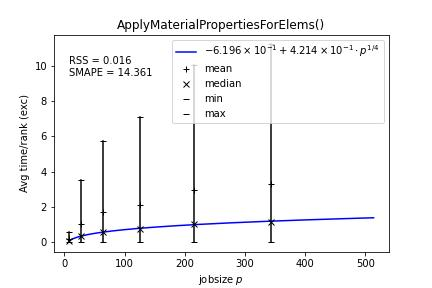
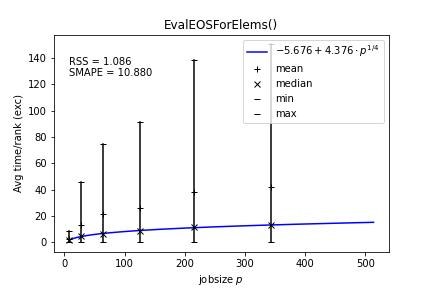
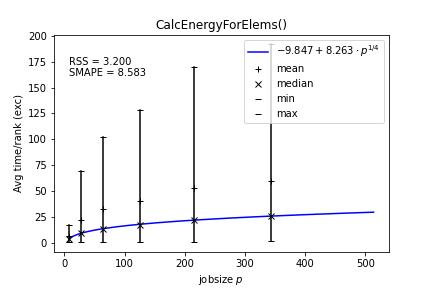
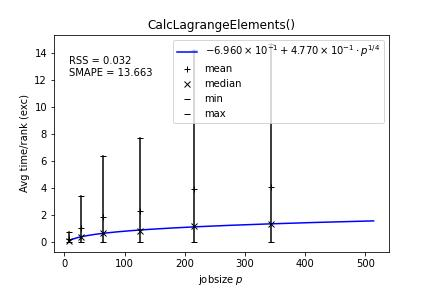
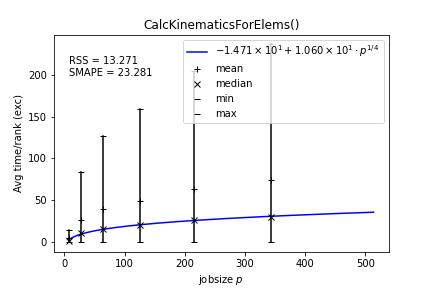
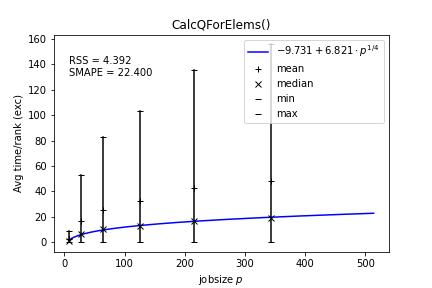
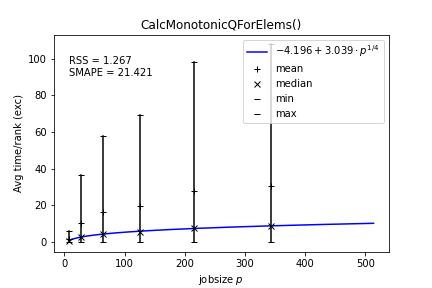
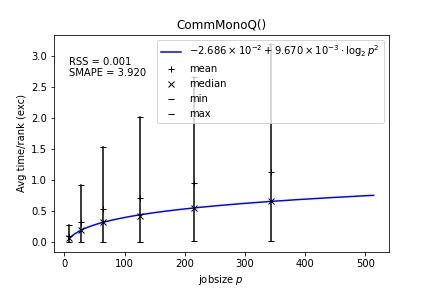
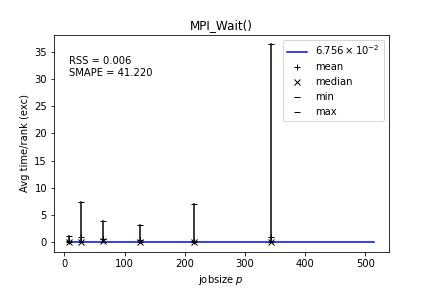
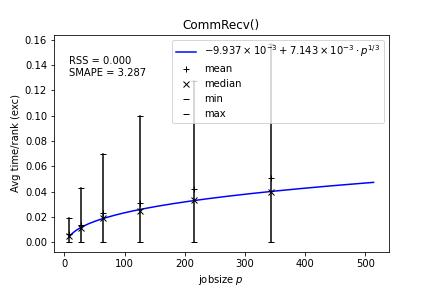
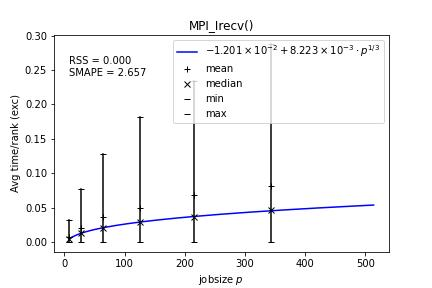
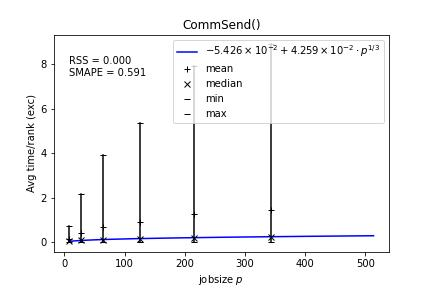
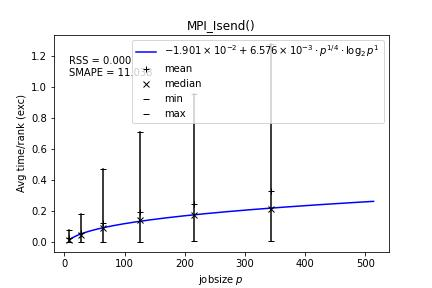
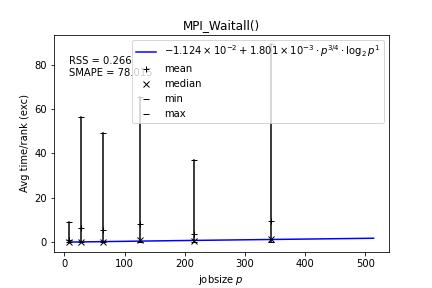
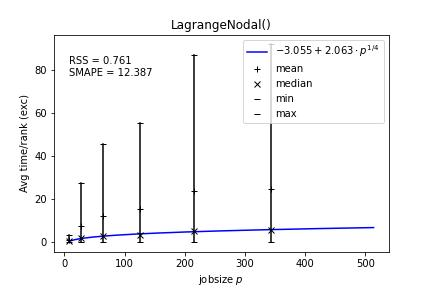
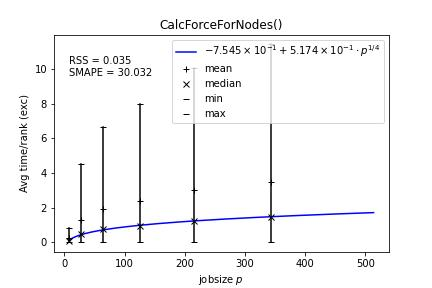
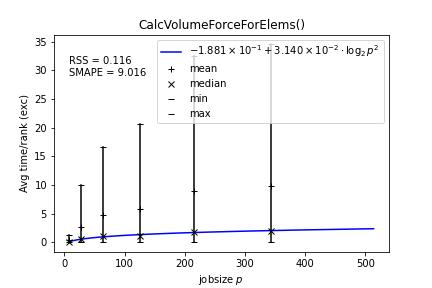
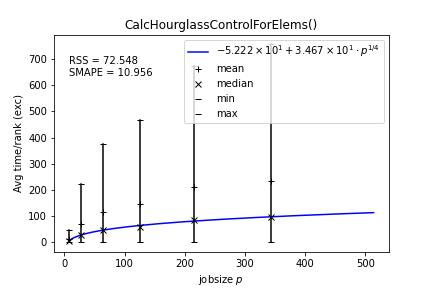
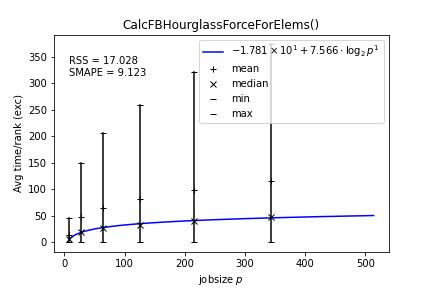
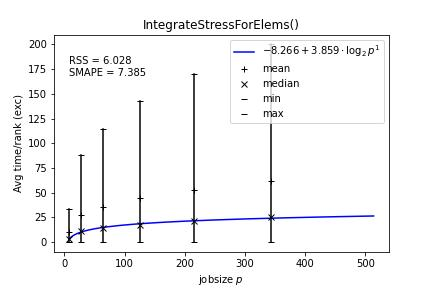
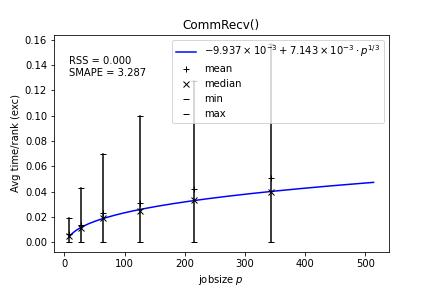
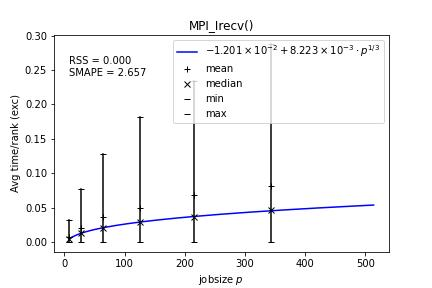
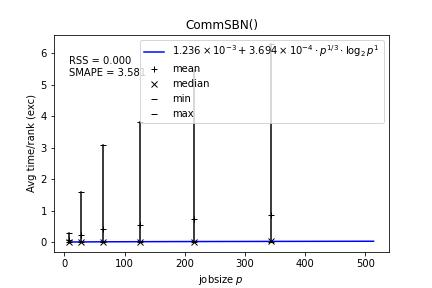
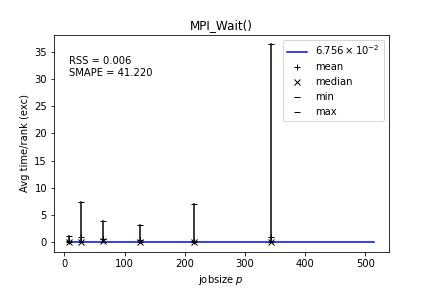
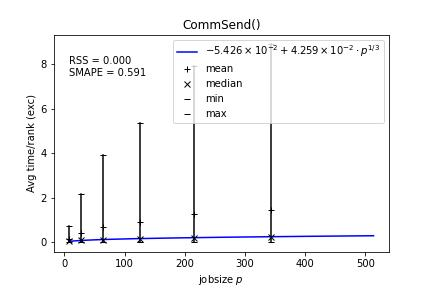
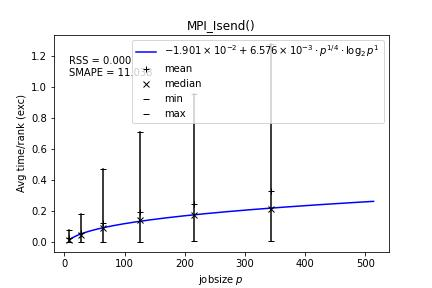
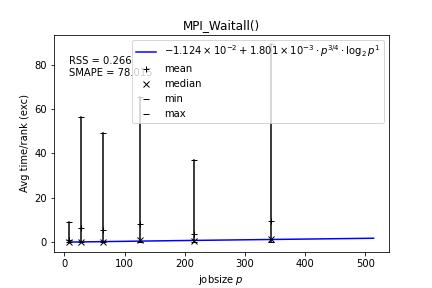
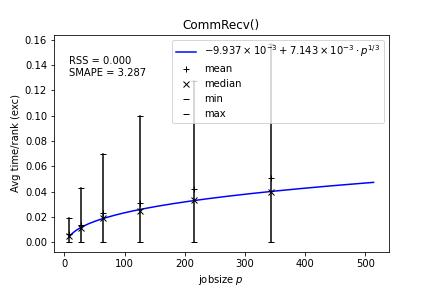
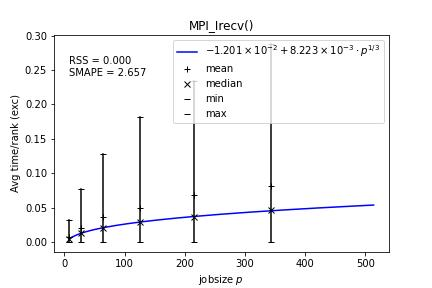
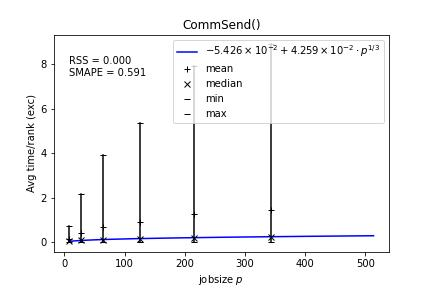
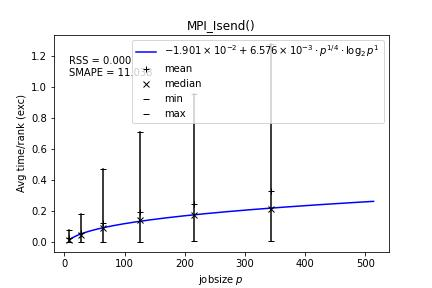
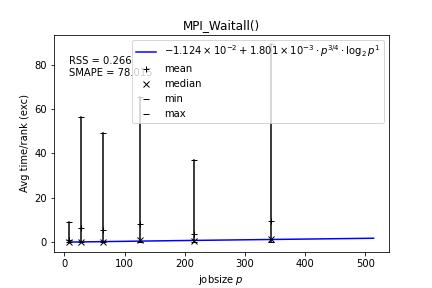
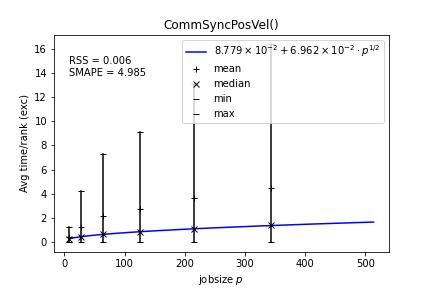
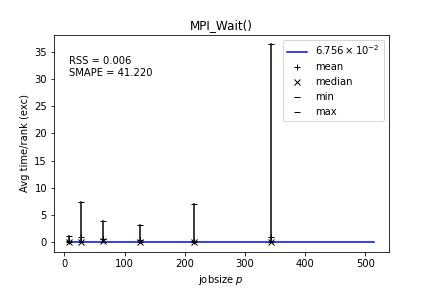
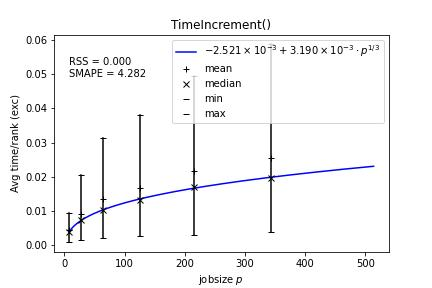
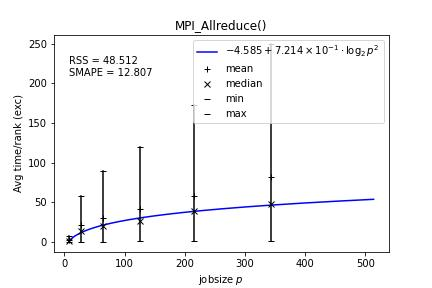

In [9]:
with pd.option_context("display.max_colwidth", 1):
    display(HTML(extrap_interface.to_html(thicket, show_mean=True, show_median=True, show_min_max=True, RSS=True, SMAPE=True)))

### Displaying Multi-Parameter Data

To display multi-parameter models one can simply use the same functions as for single-parameter models. The method itself will figure out how many model parameters exist and choose the correct function to display your results.

,Avg time/rank (exc)_extrap-model
node,
"{'name': 'MPI_Barrier', 'type': 'function'}",
"{'name': 'MPI_Comm_dup', 'type': 'function'}",
"{'name': 'MPI_Finalize', 'type': 'function'}",
"{'name': 'MPI_Finalized', 'type': 'function'}",
"{'name': 'MPI_Initialized', 'type': 'function'}",
"{'name': 'main', 'type': 'function'}",
"{'name': 'CommRecv', 'type': 'function'}",
"{'name': 'MPI_Irecv', 'type': 'function'}",
"{'name': 'CommSBN', 'type': 'function'}",

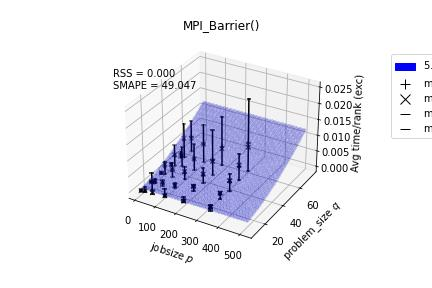
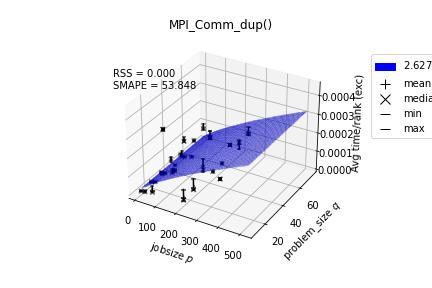
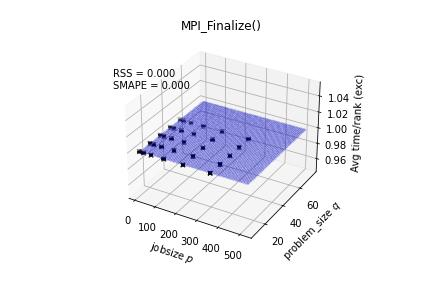
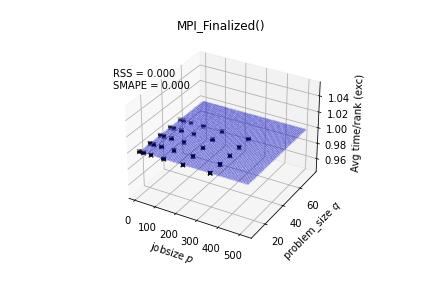
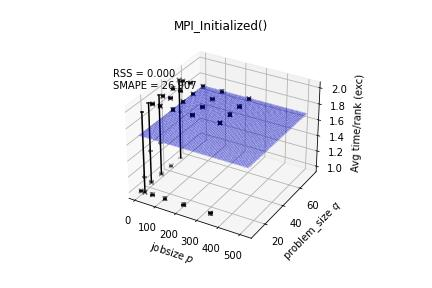
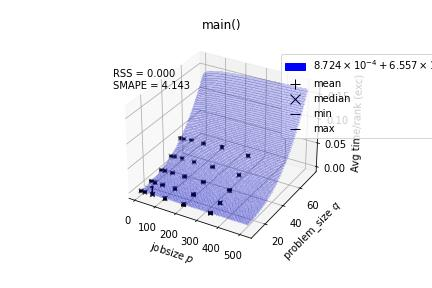
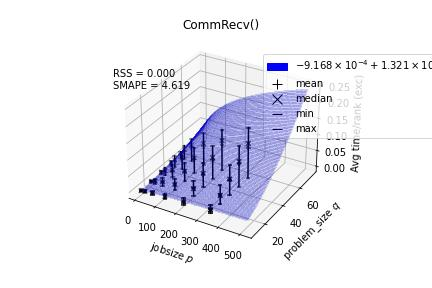
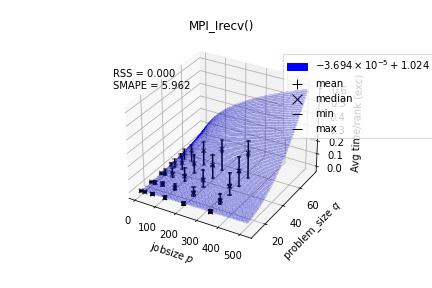
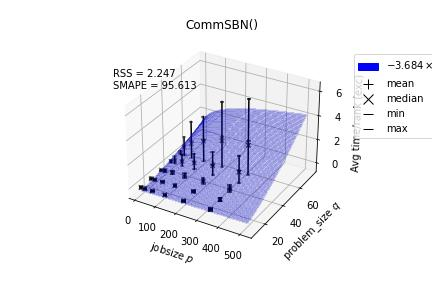
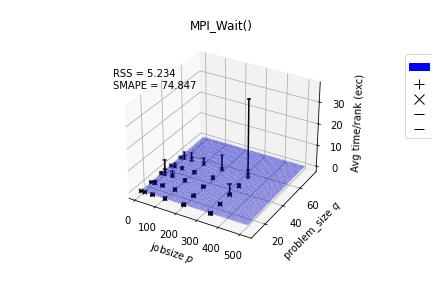
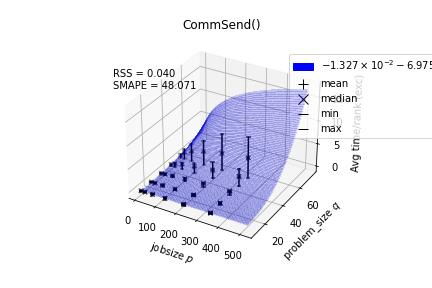
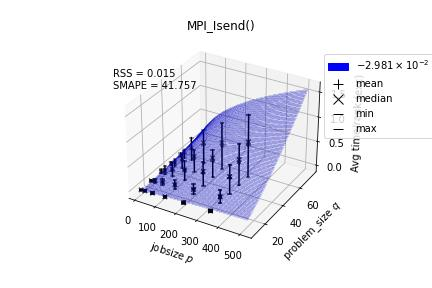
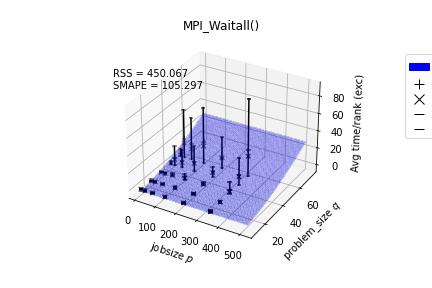
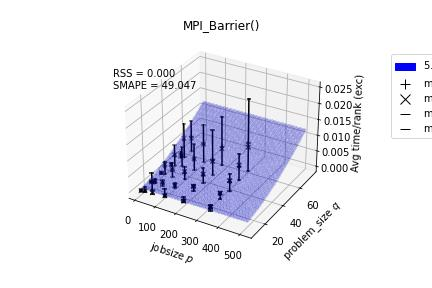
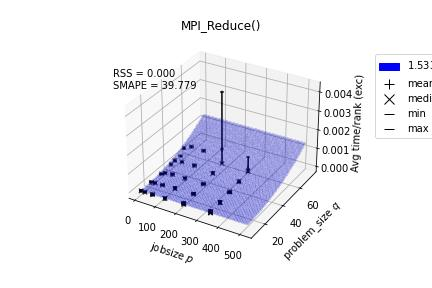
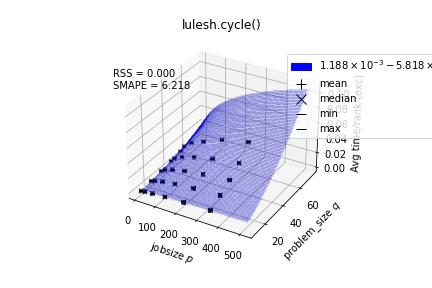
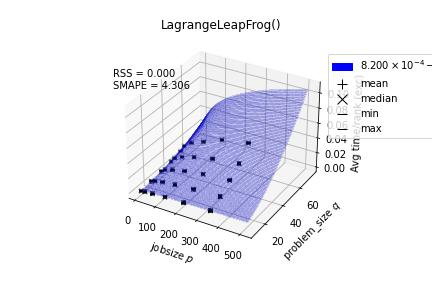
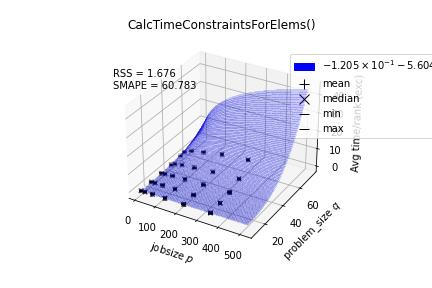
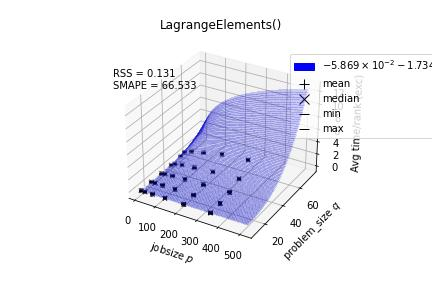
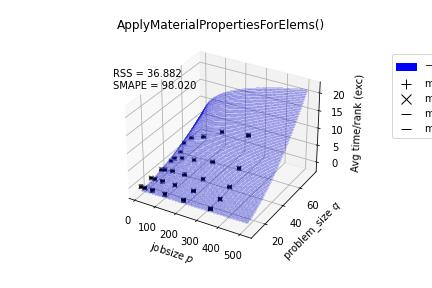
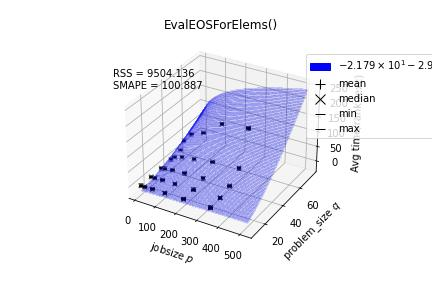
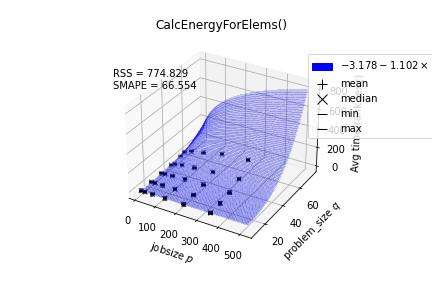
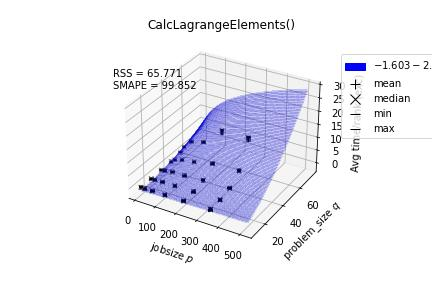
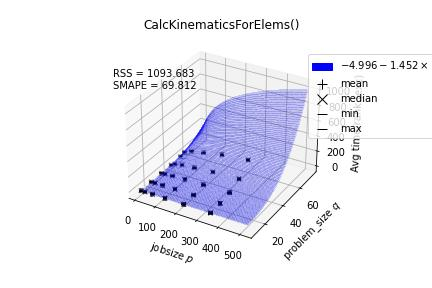
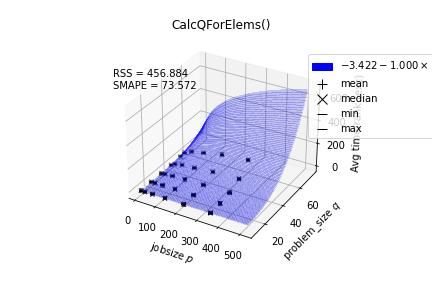
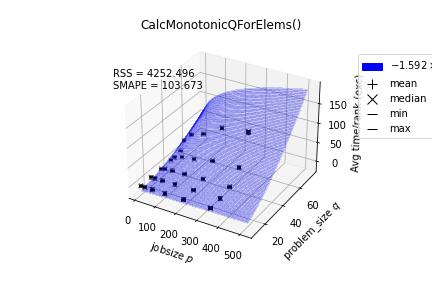
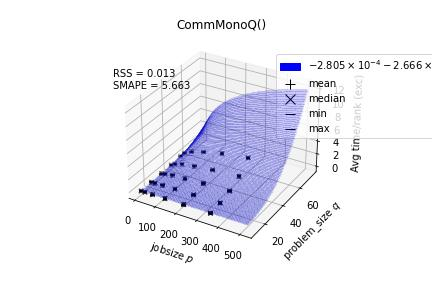
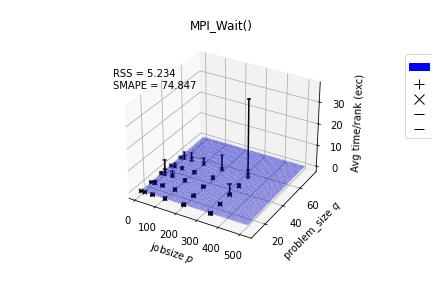
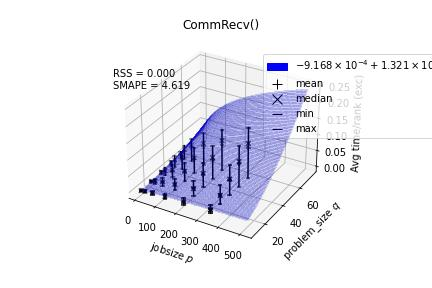
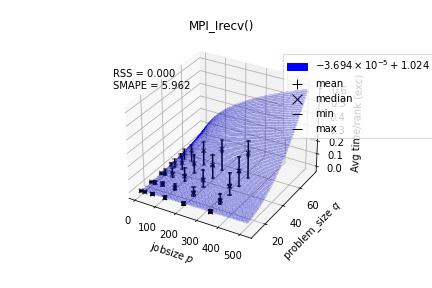
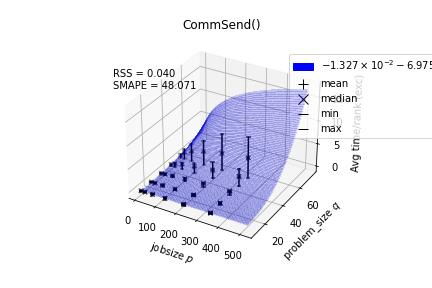
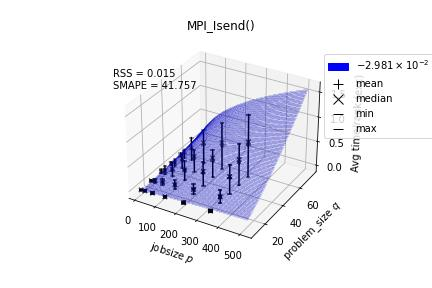
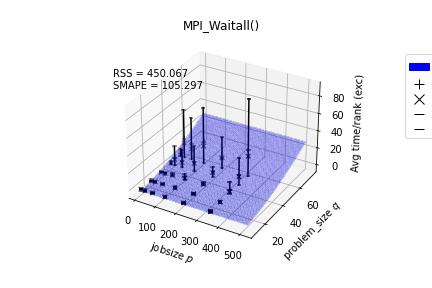
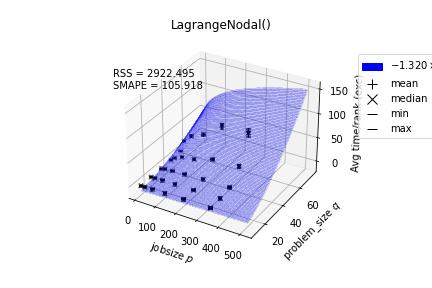
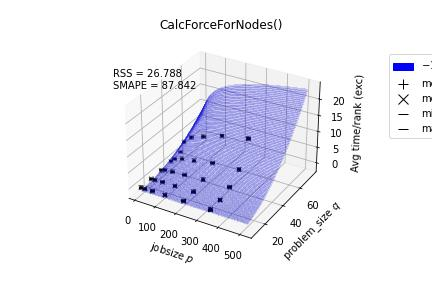
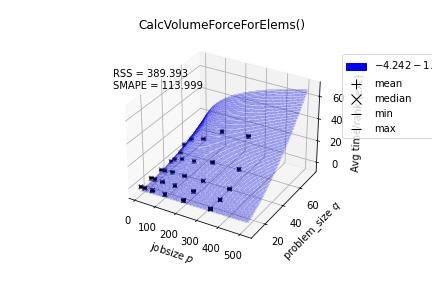
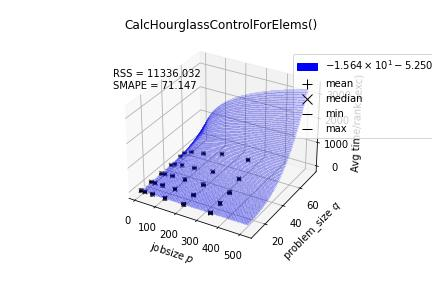
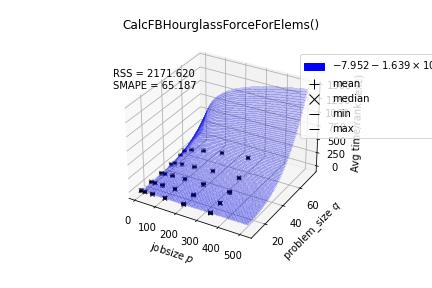
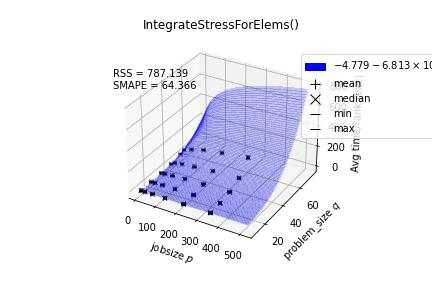
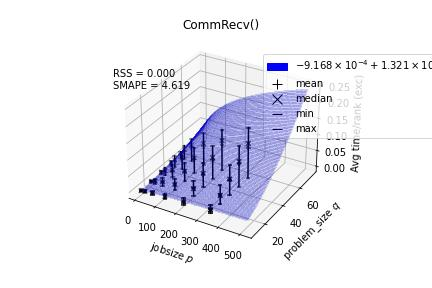
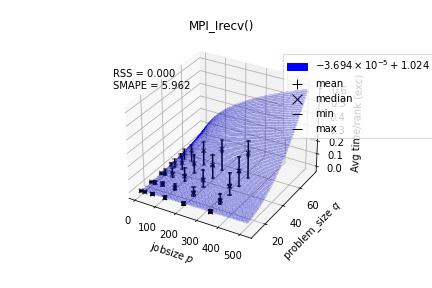
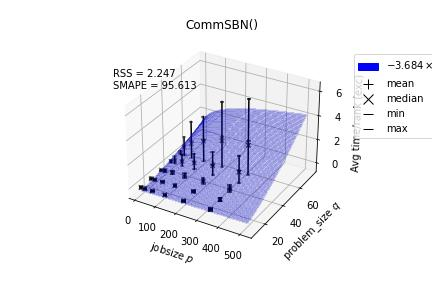
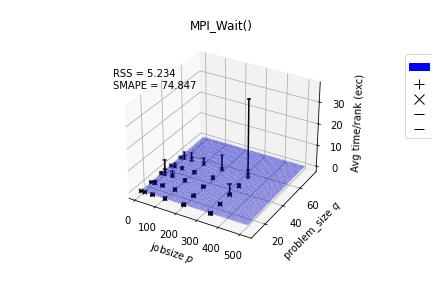
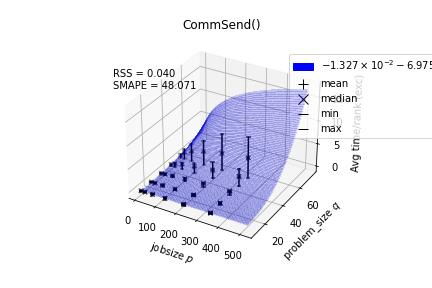
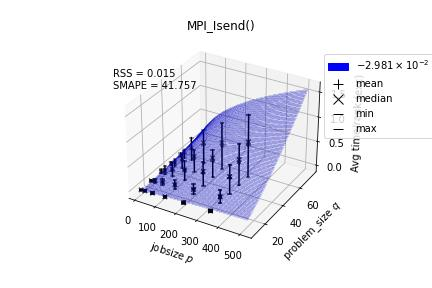
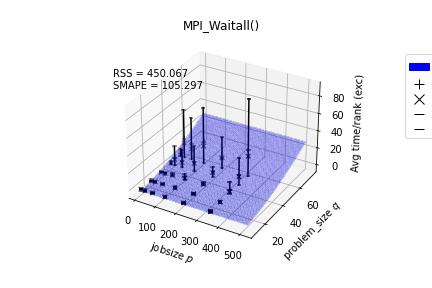
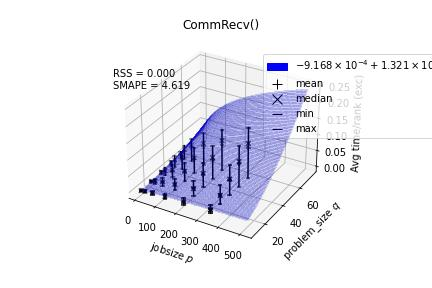
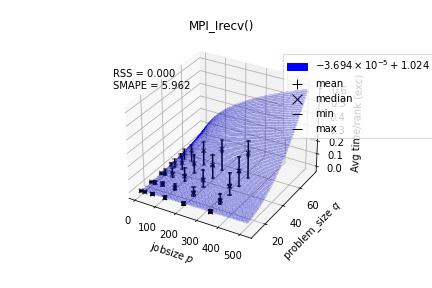
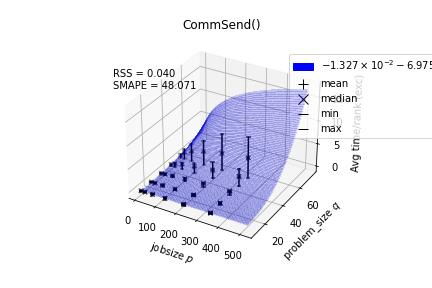
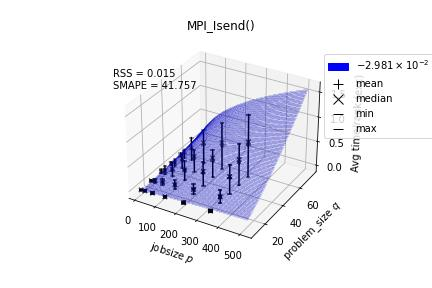
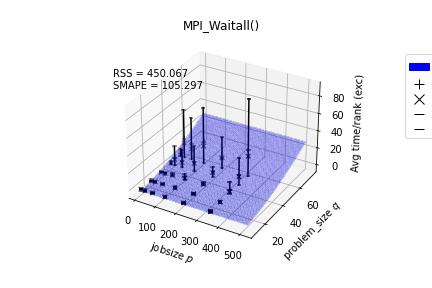
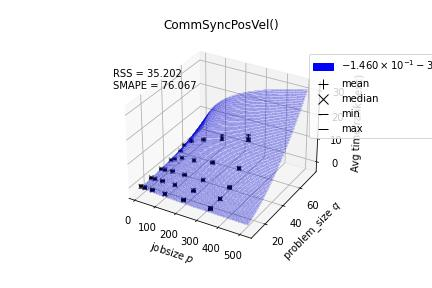
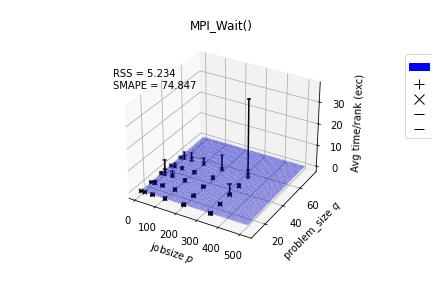
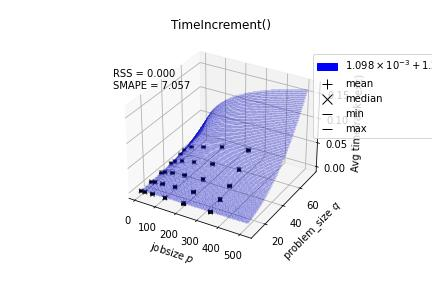
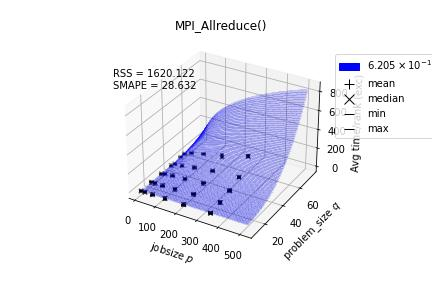

In [10]:
with pd.option_context("display.max_colwidth", 1):
    display(HTML(extrap_interface_multi.to_html(thicket_multi, show_mean=True, show_median=True, show_min_max=True, RSS=True, SMAPE=True)))

## 6. Query Specific Model

The last node `{"name": "MPI_Allreduce", "type": "function"}`, has an interesting graph so we want to retrieve its model. This can be achieved by indexing the `models_df` DataFrame for our chosen node for the metric `Avg time/rank (exc)_extrap-model`.

In [11]:
model_obj = thicket.statsframe.dataframe.at[thicket.statsframe.dataframe.index[len(thicket.statsframe.dataframe.index)-1], "Avg time/rank (exc)_extrap-model"]

You can also get the function of a model via the model object as shown below.

In [12]:
model_obj.mdl.hypothesis.function.to_string()

'-4.585159890717686+0.7213882551682822*log2(p)**(2)'

## 7. Operations on a model

To predict a metric value for a specific configuration of the chosen model parameters, we can evaluate the model like a function by simply providing the values of the chosen parameters.

In [13]:
model_obj.eval(600)

56.85626730517517

### Displaying the model:

It returns a _figure_ and an _axis_ objects. The axis object can be used to adjust the plot, i.e., change labels. The `display()` function features several optional input variables that change they way how the data is displayed. For example we can set the `RSS` (bool) value, that determines whether to display Extra-P RSS on the plot. Furthermore, we can show the min, max, mean, and median measured metric values again. Finally, we have the option to display an "optimal" scaling model. If one has an idea how the function should scale like, this expectation function can be enetered as shown in the example code below. The plot then shows the expected metric value compared to the created Extra-P model, ready for comparison.

<Figure size 432x288 with 0 Axes>

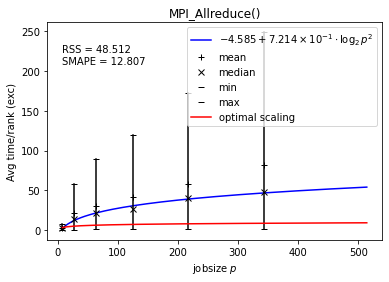

In [14]:
plt.clf()
fig, ax = model_obj.display(show_mean=True, show_median=True, 
                            show_min_max=True, 
                            RSS=True, SMAPE=True, show_opt_scaling=True,
                            opt_scaling_func="log2(p)**1")
plt.show()
plt.close()

The same is true when plotting the results of a multi-parameter model. An example is shown below.

<Figure size 432x288 with 0 Axes>

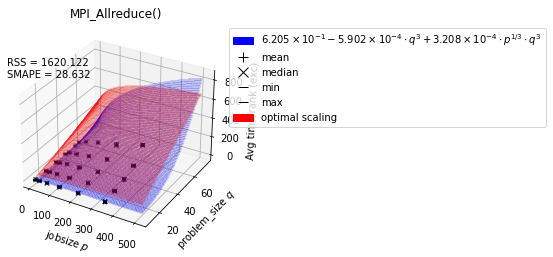

In [31]:
model_obj_multi = thicket_multi.statsframe.dataframe.at[thicket_multi.statsframe.dataframe.index[len(thicket_multi.statsframe.dataframe.index)-1], "Avg time/rank (exc)_extrap-model"]
plt.clf()
fig, ax = model_obj_multi.display(show_mean=True, show_median=True, 
                            show_min_max=True, 
                            RSS=True, SMAPE=True, show_opt_scaling=True,
                            opt_scaling_func="q*log2(p)**1")
plt.show()
plt.close()

If you want an interactive matplotlib chart you can set `%matplotlib widget` in the notebook.

## 8. Weak and strong scaling support

Extra-P can model measurement data from weak and strong scaling experiments. The examples shown in the previous cells all used weak scaling. To create a model using data from a strong scaling experiment, Extra-P uses a workaround. Essentially it converts the data from the strong scaling experiment to a weak scaling experiment. As a consequence metric values, e.g., the runtime increases the larger the jobsize. This might me confusing at first as one would expect the runtime to decrease the larger the jobsize. When analyzing the scalability of the created models one has to think of it as a weak scaling experiment instead of strong scaling.

In [15]:
data_strong = "../data/lulesh_strong"
thicket_strong = th.Thicket.from_caliperreader(data_strong)
extrap_interface_strong = ExtrapInterface()

### Creating models for strong scaling measurements:

To use this functionality we simply have to set the variable `calc_total_metrics=True` of the `create_models()` function. In addition we need to specify the scaling parameter of the performance experiment, which is usually the resource allocation, e.g., the number of MPI ranks. In this example the *jobsize* corresponds to the number of MPI ranks the application was executed with. Therefore, we set `scaling_parameter="jobsize"` accordingly. Based on this information Extra-P multiplies the measured metric values with the number of MPI ranks, to convert the data from a weak into a strong scaling experiment. Though, this is only done for metrics that are measured per rank, e.g., the *Avg time/rank*. This conversion does not apply to metrics such as the *Total time* for which it would make no sense. If the `scaling` and `scaling_parameter` parameters of the `create_models()` function are not specified, the data will be automatically read as a weak scaling experiment.

In [16]:
extrap_interface_strong.create_models(thicket_strong, 
                                parameters=[
                                   "jobsize",
                                ], 
                               metrics=[
                                   "Avg time/rank",
                                   "Total time"
                                   ],
                               use_median=True,
                               calc_total_metrics=True,
                               scaling_parameter="jobsize",
                               model_name="config1")

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{1/4}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[
/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{1/4}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


### Analyzing a strong scaling experiment

Subesequently, we can analyze the data as before. We can take a look at thicket's aggregated statistics table or show the models dataframe with the embedded plots.

In [17]:
thicket_strong.statsframe.dataframe

,name,Avg time/rank_extrap-model,Avg time/rank_RSS_extrap-model,Avg time/rank_rRSS_extrap-model,Avg time/rank_SMAPE_extrap-model,Avg time/rank_AR2_extrap-model,Avg time/rank_RE_extrap-model,Total time_extrap-model,Total time_RSS_extrap-model,Total time_rRSS_extrap-model,Total time_SMAPE_extrap-model,Total time_AR2_extrap-model,Total time_RE_extrap-model
node,,,,,,,,,,,,,
"{'name': 'main', 'type': 'function'}",main,$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{...,108127.513302,0.197867,18.063053,0.884946,0.153026,$-5.618\times10^{2}+4.866\times10^{2}\cdot p^{...,108127.505764,0.197867,18.063055,0.884946,0.153026
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,$2.426\times10^{−2}+3.960\times10^{−4}\cdot p^...,0.012960,0.105481,13.097851,0.988300,0.104523,$2.426\times10^{−2}+3.960\times10^{−4}\cdot p^...,0.012974,0.105542,13.101269,0.988287,0.104551
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,$6.146$,205.586865,7.805010,64.503092,1.000000,2.096031,$6.146$,205.586658,7.804934,64.502937,1.000000,2.096066
"{'name': 'CommSend', 'type': 'function'}",CommSend,$7.370\times10^{−1}+1.640\times10^{−2}\cdot p^...,15.172398,0.182106,19.693291,0.943757,0.165481,$7.370\times10^{−1}+1.640\times10^{−2}\cdot p^...,15.172917,0.182109,19.693681,0.943755,0.165484
"{'name': 'lulesh.cycle', 'type': 'function'}",lulesh.cycle,$-5.595\times10^{2}+4.855\times10^{2}\cdot p^{...,107917.105773,0.201398,18.124848,0.884649,0.153769,$-5.595\times10^{2}+4.855\times10^{2}\cdot p^{...,107917.130062,0.201398,18.124851,0.884649,0.153769
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",LagrangeLeapFrog,$-2.583\times10^{2}+1.563\times10^{2}\cdot \lo...,118424.279056,0.156942,18.291172,0.729735,0.148258,$-2.583\times10^{2}+1.563\times10^{2}\cdot \lo...,118424.336814,0.156942,18.291172,0.729735,0.148258
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",CalcTimeConstraintsForElems,$1.382+4.864\times10^{−2}\cdot p^{3/4}\cdot \l...,7.413757,0.082891,10.667412,0.987705,0.090971,$1.382+4.864\times10^{−2}\cdot p^{3/4}\cdot \l...,7.413584,0.082882,10.667008,0.987705,0.090966
"{'name': 'LagrangeElements', 'type': 'function'}",LagrangeElements,$-1.231\times10^{1}+1.790\times10^{1}\cdot p^{...,28904.271782,0.171095,18.997777,0.842693,0.150553,$-1.231\times10^{1}+1.790\times10^{1}\cdot p^{...,28904.303367,0.171095,18.997782,0.842693,0.150553
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",ApplyMaterialPropertiesForElems,$1.497\times10^{1}+5.970\cdot p^{3/4}$,5322.415026,0.090452,12.408115,0.954521,0.098806,$1.497\times10^{1}+5.970\cdot p^{3/4}$,5322.410114,0.090452,12.408118,0.954521,0.098806


When analyzing the models dataframe with the embedded plots, we see that models for the metrics *Avg time/rank, Total time*. are almost perfectly identical. This should be the case and indicates that the strong scaling data was correctly converted into a weak scaling experiment.

In this case both metrics are showing redundant information as we intentionally measured the total time to highlight the conversion process. In reality the *Total time* might not be available as a metric. 

Subsequently, one can analyze and display the created models as before.

<Figure size 432x288 with 0 Axes>

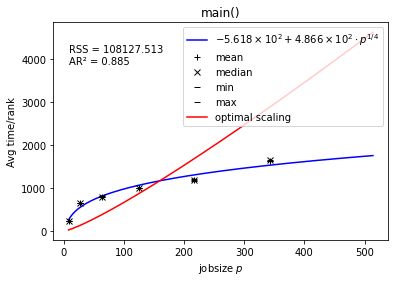

In [18]:
model_obj = thicket_strong.statsframe.dataframe.at[thicket_strong.statsframe.dataframe.index[0], "Avg time/rank_extrap-model"]
plt.clf()
fig, ax = model_obj.display(show_mean=True, show_median=True, 
                            show_min_max=True, RSS=True, 
                            AR2=True, show_opt_scaling=True,
                            opt_scaling_func="p**1*log2(p)**1")
ax.legend(loc=1)
plt.show()
plt.close()

## 9. Extra-P Modeler Configuration Support

Extra-P feastures several modeling techniques that are used to create performance models. Depending on the modeling problem at hand one might perform better than another. More information about this can be found in the Extra-P documentation at: [Extra-P](https://github.com/extra-p/extrap).

To show the available modelers from Extra-P that can be used for modeling one can run the below code.

In [19]:
data = "../data/lulesh/"
thicket = th.Thicket.from_caliperreader(data)
extrap_interface = ExtrapInterface()
extrap_interface.print_modelers()

Available Extra-P Modeler: ['basic', 'refining', 'multi-parameter', 'default']


Furthermore, each modeler has a specific set of configuration options that determine how the models are created and for example define the search space for the models.
To query these options for a specific modeler one can use the following code.

In [20]:
extrap_interface.print_modeler_options("default")

Modeler Options
--------------
allow_log_terms	 BOOL	 Allows models with logarithmic terms
use_crossvalidation	 BOOL	 Enables cross-validation
compare_with_RSS	 BOOL	 If enabled the models are compared using their residual sum of squares (RSS) instead of their symmetric mean absolute percentage error (SMAPE)
poly_exponents	 STR	 Set of polynomial exponents. Use comma separated list.
log_exponents	 STR	 Set of logarithmic exponents. Use comma separated list.
retain_default_exponents	 BOOL	 If set the default exponents are added to the given ones.
force_combination_exponents	 BOOL	 If set the exact combination of exponents is forced.
allow_negative_exponents	 BOOL	 If set adds neagtive exponents for strong scaling.



If you want to explore Extra-P's modeling capabilities you can try to use a different modeler and see the difference in models it will return. To change the model generator Extra-P will use specify the name of the modeler as shown below. Here we use the refining modeler instead, which automatically adjusts the search space of the models for the user. Therefore, there is no need to specify the exponents Extra-P should use for modeling.
Furthermore, this example shows how to create models for several parameters and metrics.
To create models for several parameters or metrics simply provide them as a list of string values.

There are several additional parameters to this method. For example, one can use the parameter `use_median=True` to switch between using the median and mean values of the measured performance metrics values of a measurement point (application configuration) for modeling.

The `add_stats=True` parameter let's you specify if you want to have Extra-P's statistical values extended to the dataframe object of thicket. These values are internally used by Extra-P to decide which of the found hypotheses will be the best model for a certain node/kernel and metric.

In [21]:
extrap_interface.create_models(thicket, 
                               parameters=[
                                   "jobsize"
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)",
                                   "Avg time/rank"
                                   ], 
                               use_median=True,
                               modeler="refining",
                               model_name="config1")

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$1.699\times10^{−3}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[
/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$1.699\times10^{−3}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


For advanced users, you can specific which options Extra-P should use when creating the models. This will influence the type of models you will get.
Define the modeler options that you want to use for modeling in the form of a dictonary and pass them to the create_models() function of the extrap interface.
Use the previously shown `print_modeler_options("default")` function to display which options are available for a specific modeler.
Make sure that the options you are setting are available for the modeler that you specified via `modeler=""`. If not the Extra-P interface will let you know and continue using the default options.

In [22]:
modeler_options = {'allow_log_terms': True,
                   'use_crossvalidation': True,
                   'compare_with_RSS': False,
                   'poly_exponents': "0,1,2,3,4,5",
                   'log_exponents': "0,1,2",
                  }

extrap_interface.create_models(thicket, 
                               parameters=[
                                   "jobsize"
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)",
                                   ], 
                               use_median=True,
                               modeler="default",
                               model_name="config2",
                               modeler_options=modeler_options)

/usr/WS2/ritter5/thicket/thicket/model_extrap.py:1282: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \log_2{p}^{1}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tht.statsframe.dataframe.at[


Then one can display the models as before using the following code. Now the datframe has a multi-column index, using the name of the specified `model_name` parameter of the `create_models` function.
Take a look how one of the configurations has performance models for two metrics and the other one has only one. It is also possible to consider differen model parameters for each modeling configuration.

In [23]:
thicket.statsframe.dataframe

config1  \
                                                                               name   
node                                                                                  
{'name': 'MPI_Barrier', 'type': 'function'}                             MPI_Barrier   
{'name': 'MPI_Comm_dup', 'type': 'function'}                           MPI_Comm_dup   
{'name': 'MPI_Finalize', 'type': 'function'}                           MPI_Finalize   
{'name': 'MPI_Finalized', 'type': 'function'}                         MPI_Finalized   
{'name': 'MPI_Initialized', 'type': 'function'}                     MPI_Initialized   
{'name': 'main', 'type': 'function'}                                           main   
{'name': 'CommRecv', 'type': 'function'}                                   CommRecv   
{'name': 'MPI_Irecv', 'type': 'function'}                                 MPI_Irecv   
{'name': 'CommSBN', 'type': 'function'}                                     CommSBN   
{'name': 'MPI_Wait', 'type': 'function'}                                   MPI_Wait   
{'name': 'CommSend', 'type': 'function'}                                   CommSend   
{'name': 'MPI_Isend', 'type': 'function'}                                 MPI_Isend   
{'name': 'MPI_Waitall', 'type': 'function'}                             MPI_Waitall   
{'name': 'MPI_Barrier', 'type': 'function'}                             MPI_Barrier   
{'name': 'MPI_Reduce', 'type': 'function'}                               MPI_Reduce   
{'name': 'lulesh.cycle', 'type': 'function'}                           lulesh.cycle   
{'name': 'LagrangeLeapFrog', 'type': 'function'}                   LagrangeLeapFrog   
{'name': 'CalcTimeConstraintsForElems', 'type':...      CalcTimeConstraintsForElems   
{'name': 'LagrangeElements', 'type': 'function'}                   LagrangeElements   
{'name': 'ApplyMaterialPropertiesForElems', 'ty...  ApplyMaterialPropertiesForElems   
{'name': 'EvalEOSForElems', 'type': 'function'}                     EvalEOSForElems   
{'name': 'CalcEnergyForElems', 'type': 'function'}               CalcEnergyForElems   
{'name': 'CalcLagrangeElements', 'type': 'funct...             CalcLagrangeElements   
{'name': 'CalcKinematicsForElems', 'type': 'fun...           CalcKinematicsForElems   
{'name': 'CalcQForElems', 'type': 'function'}                         CalcQForElems   
{'name': 'CalcMonotonicQForElems', 'type': 'fun...           CalcMonotonicQForElems   
{'name': 'CommMonoQ', 'type': 'function'}                                 CommMonoQ   
{'name': 'MPI_Wait', 'type': 'function'}                                   MPI_Wait   
{'name': 'CommRecv', 'type': 'function'}                                   CommRecv   
{'name': 'MPI_Irecv', 'type': 'function'}                                 MPI_Irecv   
{'name': 'CommSend', 'type': 'function'}                                   CommSend   
{'name': 'MPI_Isend', 'type': 'function'}                                 MPI_Isend   
{'name': 'MPI_Waitall', 'type': 'function'}                             MPI_Waitall   
{'name': 'LagrangeNodal', 'type': 'function'}                         LagrangeNodal   
{'name': 'CalcForceForNodes', 'type': 'function'}                 CalcForceForNodes   
{'name': 'CalcVolumeForceForElems', 'type': 'fu...          CalcVolumeForceForElems   
{'name': 'CalcHourglassControlForElems', 'type'...     CalcHourglassControlForElems   
{'name': 'CalcFBHourglassForceForElems', 'type'...     CalcFBHourglassForceForElems   
{'name': 'IntegrateStressForElems', 'type': 'fu...          IntegrateStressForElems   
{'name': 'CommRecv', 'type': 'function'}                                   CommRecv   
{'name': 'MPI_Irecv', 'type': 'function'}                                 MPI_Irecv   
{'name': 'CommSBN', 'type': 'function'}                                     CommSBN   
{'name': 'MPI_Wait', 'type': 'function'}                                   MPI_Wait   
{'name': 'CommSend', 'type': 'function'}                                  

Using the multi-column index one can also simply only analyze one of the configurations used for modeling with Extra-P as shown below.

In [24]:
thicket.statsframe.dataframe["config2"]

,name,Avg time/rank (exc)_extrap-model,Avg time/rank (exc)_RSS_extrap-model,Avg time/rank (exc)_rRSS_extrap-model,Avg time/rank (exc)_SMAPE_extrap-model,Avg time/rank (exc)_AR2_extrap-model,Avg time/rank (exc)_RE_extrap-model
node,,,,,,,
"{'name': 'MPI_Barrier', 'type': 'function'}",MPI_Barrier,$-1.039\times10^{−3}+4.453\times10^{−4}\cdot \...,1.447227e-06,8.545707,48.405904,0.617853,0.685289
"{'name': 'MPI_Comm_dup', 'type': 'function'}",MPI_Comm_dup,$2.461\times10^{−5}+6.173\times10^{−7}\cdot p^...,4.933832e-08,8.210311,75.944515,-0.086425,0.874395
"{'name': 'MPI_Finalize', 'type': 'function'}",MPI_Finalize,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Finalized', 'type': 'function'}",MPI_Finalized,$10^{−6}$,0.000000e+00,0.000000,0.000000,1.000000,0.000000
"{'name': 'MPI_Initialized', 'type': 'function'}",MPI_Initialized,$1.833\times10^{−6}$,8.333333e-13,0.729167,17.050298,1.000000,0.833333
"{'name': 'main', 'type': 'function'}",main,$8.209\times10^{−3}+3.719\times10^{−4}\cdot \l...,6.126005e-07,0.006114,3.256699,0.743588,0.027427
"{'name': 'CommRecv', 'type': 'function'}",CommRecv,$-1.426\times10^{−3}+5.736\times10^{−4}\cdot \...,1.005014e-05,0.142954,12.355379,0.985958,0.089820
"{'name': 'MPI_Irecv', 'type': 'function'}",MPI_Irecv,$-2.201\times10^{−3}+6.601\times10^{−4}\cdot \...,1.426882e-05,0.157177,13.547134,0.984935,0.097689
"{'name': 'CommSBN', 'type': 'function'}",CommSBN,$-4.003\times10^{−4}+3.156\times10^{−4}\cdot \...,8.406269e-06,0.330874,21.119549,0.961369,0.140469


The same goes for displaying the models. By specifying the name of the configuration we can access only the model configuration we want to analyse using the multi-column index.

<Figure size 432x288 with 0 Axes>

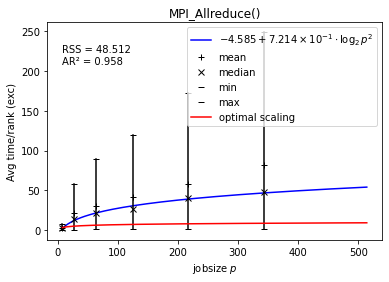

In [25]:
model_obj = thicket.statsframe.dataframe["config2"].at[thicket.statsframe.dataframe.index[len(thicket.statsframe.dataframe.index)-1], "Avg time/rank (exc)_extrap-model"]
plt.clf()
fig, ax = model_obj.display(show_mean=True, show_median=True, 
                            show_min_max=True, RSS=True, 
                            AR2=True, show_opt_scaling=True,
                            opt_scaling_func="log2(p)**1")
plt.show()
plt.close()


### Modeler Configuration for Multi-Parameter Models

For multi-parameter models more modeler configuration options are available. First, one can query the options of our multi-parameter modeler as shown below.

In [26]:
extrap_interface.print_modeler_options("multi-parameter")

Modeler Options
--------------
single_parameter_point_selection	 ['auto', 'smallest', 'all']	 Sets the point selection method for creating the single-parameter models.
allow_combinations_of_sums_and_products	 BOOL	 Allows models that consist of combinations of sums and products.
compare_with_RSS	 BOOL	 If enabled the models are compared using their residual sum of squares (RSS) instead of their symmetric mean absolute percentage error (SMAPE)



For a multi-parameter modeling scenario one first sets the configuration parameters of the multi-parameter modeler, then the one of the single-parameter modeler used by the multi-parameter modeler.

The options are specified in a dictionary as key value pairs. The code below shows an example. To set the single-parameter modeler used by the multi-parameter modeler one has to set `'#single_parameter_modeler': "default"` in this dictionary. To set the options for the single-parameter modeler one has to set `'#single_parameter_options'` and provide a dictionary for the single-parameter modeler options as the value, e.g., `{'poly_exponents': "0,1,2,3,4,5", 'log_exponents': "0,1,2"}`.

In [27]:
modeler_options = {'compare_with_RSS': False,
                   'allow_combinations_of_sums_and_products': True,
                   '#single_parameter_modeler': "default",
                   '#single_parameter_options': {'poly_exponents': "0,1,2,3,4,5",
                   'log_exponents': "0,1,2"},
                  }

extrap_interface.create_models(thicket, 
                               parameters=[
                                   "jobsize",
                                   "problem_size"
                                ], 
                               metrics=[
                                   "Avg time/rank (exc)"
                                   ], 
                               use_median=True,
                               modeler="multi-parameter",
                               model_name="config3",
                               modeler_options=modeler_options)

## 10. Complexity Analysis with Extra-P

Using the functionalities of Extra-P and Thicket one can easily perform a complexity analysis of the scaling behavior of all nodes in a Thicket.
Therefore, one can use the `complexity_statsframe()` function, which requires only the thicket and the evaluation target as an input. With `eval_targets=[[512]]` one specifies the target scale of the values of the considered model parameters that will be used for the evaluation of the models scaling complexity. The `complexity_statsframe()` function will add three columns to the dataframe: model complexity, the model coefficient, and the growth rank. The column names of these three columns are indexed by the specified evaluation target. The model complexity is the term of the model contributes the most to the asymptotic scaling behavior of the model for the specified evaluation target. The model coefficient is the coefficient of this model term. The growth rank is a ranking of all nodes scaling behavior compared with each other.

Furthermore, one can specify several evaluation targets such as (the three columns described above will be added for each evaluation target):

```
eval_targets=[[512]]
eval_targets=[[512],[1024],...]
```

For multiple parameters:

```
eval_targets=[[512,60]]
eval_targets=[[512,60],[1024,70],...]
```

Subsequently, we can for example sort the nodes by their growth ranks and display the dataframe. This provides some insight in which node has the fastest growing metric value at the target scale.

In [28]:
extrap_interface_multi.complexity_statsframe(thicket_multi, eval_targets=[[512,60]])
complexity_df = thicket_multi.statsframe.dataframe
complexity_df = complexity_df.sort_values(by=["Avg time/rank (exc)_extrap-model_growth_rank_(512,60)"])
complexity_df

,name,Avg time/rank (exc)_extrap-model,Avg time/rank (exc)_RSS_extrap-model,Avg time/rank (exc)_rRSS_extrap-model,Avg time/rank (exc)_SMAPE_extrap-model,Avg time/rank (exc)_AR2_extrap-model,Avg time/rank (exc)_RE_extrap-model,"Avg time/rank (exc)_extrap-model_complexity_(512,60)","Avg time/rank (exc)_extrap-model_coefficient_(512,60)","Avg time/rank (exc)_extrap-model_growth_rank_(512,60)"
node,,,,,,,,,,
"{'name': 'CalcHourglassControlForElems', 'type': 'function'}",CalcHourglassControlForElems,$-1.564\times10^{1}-5.250\times10^{−4}\cdot q^...,1.133603e+04,2.542843e+04,7.114681e+01,0.989121,1.068512e+01,p**(1/4)*q**(3)*log2(q)**(1),3.705678e-04,1
"{'name': 'CalcFBHourglassForceForElems', 'type': 'function'}",CalcFBHourglassForceForElems,$-7.952-1.639\times10^{−4}\cdot q^{3}\cdot \lo...,2.171620e+03,1.463935e+04,6.518685e+01,0.991675,7.684954e+00,log2(p)**(1)*q**(3)*log2(q)**(1),7.895069e-05,2
"{'name': 'CalcKinematicsForElems', 'type': 'function'}",CalcKinematicsForElems,$-4.996-1.452\times10^{−4}\cdot q^{3}\cdot \lo...,1.093683e+03,5.122173e+04,6.981168e+01,0.989647,1.157417e+01,p**(1/4)*q**(3)*log2(q)**(1),1.124137e-04,3
"{'name': 'MPI_Allreduce', 'type': 'function'}",MPI_Allreduce,$6.205\times10^{−1}-5.902\times10^{−4}\cdot q^...,1.620122e+03,1.632813e+02,2.863241e+01,0.978472,7.028135e-01,p**(1/3)*q**(3),3.207557e-04,4
"{'name': 'CalcEnergyForElems', 'type': 'function'}",CalcEnergyForElems,$-3.178-1.102\times10^{−4}\cdot q^{3}\cdot \lo...,7.748289e+02,1.341018e+02,6.655397e+01,0.988650,1.116354e+00,p**(1/4)*q**(3)*log2(q)**(1),8.866952e-05,5
"{'name': 'IntegrateStressForElems', 'type': 'function'}",IntegrateStressForElems,$-4.779-6.813\times10^{−5}\cdot q^{3}\cdot \lo...,7.871387e+02,1.154380e+04,6.436603e+01,0.989760,7.437430e+00,log2(p)**(1)*q**(3)*log2(q)**(1),4.010056e-05,6
"{'name': 'CalcQForElems', 'type': 'function'}",CalcQForElems,$-3.422-1.000\times10^{−4}\cdot q^{3}\cdot \lo...,4.568844e+02,5.454192e+04,7.357208e+01,0.990037,1.250722e+01,p**(1/4)*q**(3)*log2(q)**(1),7.520120e-05,7
"{'name': 'EvalEOSForElems', 'type': 'function'}",EvalEOSForElems,$-2.179\times10^{1}-2.904\times10^{−1}\cdot p^...,9.504136e+03,3.491306e+04,1.008870e+02,0.767733,1.507112e+01,p**(1/4)*q**(5/4)*log2(q)**(1),4.088665e-02,8
"{'name': 'CalcMonotonicQForElems', 'type': 'function'}",CalcMonotonicQForElems,$-1.592\times10^{1}+2.190\times10^{−2}\cdot p^...,4.252496e+03,7.672244e+05,1.036730e+02,0.813972,5.824786e+01,p**(1/4)*q**(4/3)*log2(q)**(1),2.190375e-02,9


We can pipe this information into hatchet and visualize it as a tree using the following code. In the example below each hatchet node shown the metric value and the model complexity.

In [29]:
th.median(thicket_multi, columns=["Avg time/rank (exc)"])

print(str(thicket_multi.statsframe.tree(
    metric_column='Avg time/rank (exc)_median', 
    annotation_column="Avg time/rank (exc)_extrap-model_complexity_(512,60)", 
    colormap="RdYlGn", 
    #colormap_annotations="black"
    )))


/usr/WS2/ritter5/thicket/thicket/stats/median.py:32: FutureWarning: The provided callable <function median at 0x1554d374d940> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
  df = thicket.dataframe[columns].reset_index().groupby("node").agg(np.median)


    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

0.004 [q**(7/4)] MPI_Barrier
0.000 [p**(1/2)*log2(p)**(2)] MPI_Comm_dup
0.000 [1] MPI_Finalize
0.000 [1] MPI_Finalized
0.000 [1] MPI_Initialized
0.011 [q**(5/2)*log2(q)**(2)] main
├─ 0.000 [p**(1/4)*log2(p)**(1)*q**(4/3)*log2(q)**(1)] CommRecv
│  └─ 0.001 [p**(1/3)*log2(p)**(1)*q**(9/4)] MPI_Irecv
├─ 0.000 [p**(1/4)*q**(5/4)*log2(q)**(1)] CommSBN
│  └─ 0.001 [q**(1/4)] MPI_Wait
├─ 0.000 [log2(p)**(2)*q**(5/2)*log2(q)**(2)] CommSend
│  ├─ 0.002 [p**(1/2)*q**(4/3)] MPI_Isend
│  └─ 0.000 [q**(7/4)] MPI_Waitall
├─ 0.001 [q**(7/4)] MPI_Barrier
├─ 0.000 [q**(2)*log2(q)**(2)] MPI_Reduce
└─ 0.011 [p**(1/3)*q**(4/3)*log2(q)**(1)] lulesh.cycle
   ├─ 0.011 [p**(1/4)*q**(5/3)] LagrangeLeapFrog
   │  ├─ 0.675 [p**(1/4)*q**(3)*log2(q)**(1)] CalcTimeConstraintsForElems
   │  ├─ 0.167 [p**(1/4)*

We can also replace the metric value with the calculated growth rank of each node as shown in the example below. Note that the color coding of the tree corresponds to the found model complexity, metric values, and growth ranks. The legend indicates the color coding and their values.

In [30]:
th.median(thicket_multi, columns=["Avg time/rank (exc)"])

print(str(thicket_multi.statsframe.tree(
    metric_column="Avg time/rank (exc)_extrap-model_growth_rank_(512,60)", 
    annotation_column="Avg time/rank (exc)_extrap-model_complexity_(512,60)", 
    colormap="RdYlGn", 
    invert_colormap=True,
    #colormap_annotations=""
    )))

/usr/WS2/ritter5/thicket/thicket/stats/median.py:32: FutureWarning: The provided callable <function median at 0x1554d374d940> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
  df = thicket.dataframe[columns].reset_index().groupby("node").agg(np.median)


    __          __       __         __ 
   / /_  ____ _/ /______/ /_  ___  / /_
  / __ \/ __ `/ __/ ___/ __ \/ _ \/ __/
 / / / / /_/ / /_/ /__/ / / /  __/ /_  
/_/ /_/\__,_/\__/\___/_/ /_/\___/\__/  v2023.1.1

50.000 [q**(7/4)] MPI_Barrier
52.000 [p**(1/2)*log2(p)**(2)] MPI_Comm_dup
55.000 [1] MPI_Finalize
54.000 [1] MPI_Finalized
53.000 [1] MPI_Initialized
46.000 [q**(5/2)*log2(q)**(2)] main
├─ 44.000 [p**(1/4)*log2(p)**(1)*q**(4/3)*log2(q)**(1)] CommRecv
│  └─ 40.000 [p**(1/3)*log2(p)**(1)*q**(9/4)] MPI_Irecv
├─ 28.000 [p**(1/4)*q**(5/4)*log2(q)**(1)] CommSBN
│  └─ 36.000 [q**(1/4)] MPI_Wait
├─ 24.000 [log2(p)**(2)*q**(5/2)*log2(q)**(2)] CommSend
│  ├─ 32.000 [p**(1/2)*q**(4/3)] MPI_Isend
│  └─ 18.000 [q**(7/4)] MPI_Waitall
├─ 49.000 [q**(7/4)] MPI_Barrier
├─ 51.000 [q**(2)*log2(q)**(2)] MPI_Reduce
└─ 47.000 [p**(1/3)*q**(4/3)*log2(q)**(1)] lulesh.cycle
   ├─ 48.000 [p**(1/4)*q**(5/3)] LagrangeLeapFrog
   │  ├─ 12.000 [p**(1/4)*q**(3)*log2(q)**(1)] CalcTimeConstraintsForElems
   │  ├